## Credit Default Model Development - Framework Comparison
This notebook implements a baseline credit default prediction model, comparing traditional pandas/scikit-learn implementation with RAPIDS/cuDF GPU-accelerated approach. The workflow demonstrates fundamental data processing steps including handling missing values, encoding categorical variables, and training an XGBoost classifier. Each implementation follows identical steps: loading train/test parquet files, preprocessing data, training the model, and evaluating performance through confusion matrices and feature importance analysis. The notebook provides a clear comparison of CPU vs GPU approaches for standard machine learning workflows, serving as a foundation for more advanced modeling techniques.

In [1]:
# Common imports
import time
import os
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# === Pandas Implementation Imports ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# === RAPIDS Implementation Imports ===
import cudf
from cuml.model_selection import train_test_split as cu_train_test_split
from cuml.metrics import confusion_matrix as cu_confusion_matrix
import xgboost as xgb  # XGBoost works with both implementations

In [4]:
## Timing Decorator Function
def time_operation(description):
    """Decorator to time operations"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            start = time.time()
            result = func(*args, **kwargs)
            duration = time.time() - start
            print(f"{description}: {duration:.2f} seconds")
            return result
        return wrapper
    return decorator

### Data Loading

In [5]:
# === Pandas Implementation ===
@time_operation("Pandas Load")
def load_data_pandas():
    train = pd.read_parquet('raw_data/train.parquet')
    test = pd.read_parquet('raw_data/test.parquet')
    return train, test

# === RAPIDS Implementation ===
@time_operation("RAPIDS Load")
def load_data_rapids():
    train = cudf.read_parquet('raw_data/train.parquet')
    test = cudf.read_parquet('raw_data/test.parquet')
    return train, test

In [6]:
os.chdir('/home/cdsw')

In [8]:
# Run both implementations
train_pd, test_pd = load_data_pandas()
train_cu, test_cu = load_data_rapids()

Pandas Load: 0.21 seconds
RAPIDS Load: 0.18 seconds


### Data Preprocessing

In [9]:
# === Pandas Implementation ===
@time_operation("Pandas Preprocessing")
def preprocess_pandas(train, test):
    # Handle missing values
    missing_threshold = 40
    missing_pct = train.isnull().sum() / len(train) * 100
    drop_cols = missing_pct[missing_pct >= missing_threshold].index
    
    train = train.drop(drop_cols, axis=1)
    test = test.drop(drop_cols, axis=1)
    
    # Split target
    train_target = train['TARGET']
    train = train.drop('TARGET', axis=1)
    
    # Handle categorical variables
    unified = pd.concat([train, test])
    cat_columns = unified.select_dtypes(['bool', 'object', 'category']).columns
    unified = pd.get_dummies(unified, columns=cat_columns, dtype='int64')
    
    # Split back
    train = unified[:len(train)]
    test = unified[len(train):]
    
    return train, test, train_target

In [10]:
# === RAPIDS Implementation ===
@time_operation("RAPIDS Preprocessing")
def preprocess_rapids(train, test):
    # Handle missing values
    missing_threshold = 40
    missing_pct = train.isnull().sum() / len(train) * 100
    drop_cols = missing_pct[missing_pct >= missing_threshold].index.to_arrow().to_pylist()
    
    train = train.drop(drop_cols, axis=1)
    test = test.drop(drop_cols, axis=1)
    
    # Split target
    train_target = train['TARGET']
    train = train.drop('TARGET', axis=1)
    
    # Handle categorical variables
    unified = cudf.concat([train, test])
    cat_columns = unified.select_dtypes(['bool', 'O', 'category']).columns.tolist()
    #cat_columns = unified.select_dtypes(['bool', 'object', 'category']).columns.to_array()
    
    unified = cudf.get_dummies(unified, columns=cat_columns, dtype='int64')
    
    # Split back
    train = unified[:len(train)]
    test = unified[len(train):]
    
    return train, test, train_target

### Model Training

In [11]:
# === CPU Implementation ===
@time_operation("CPU Training")
def train_model_cpu(X_train, y_train, X_test, y_test):
    ratio = float((y_train == 0).sum() / (y_train == 1).sum())
    
    model = xgb.XGBClassifier(
        n_estimators=1000,
        objective='binary:logistic',
        tree_method='hist',  # CPU tree method
        gamma=0.1,
        subsample=0.5,
        scale_pos_weight=ratio
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    return model

In [12]:
# === RAPIDS/GPU Implementation ===
@time_operation("GPU Training")
def train_model_gpu(X_train, y_train, X_test, y_test):
    ratio = float((y_train == 0).sum() / (y_train == 1).sum())
    
    model = xgb.XGBClassifier(
        n_estimators=1000,
        objective='binary:logistic',
        #tree_method='gpu_hist',  # GPU tree method
        tree_method='hist',
        gamma=0.1,
        subsample=0.5,
        scale_pos_weight=ratio,
        device='cuda'
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    return model

### Model Evaluation

In [13]:
def evaluate_model(model, X_test, y_test, framework="pandas"):
    """Evaluate model and print metrics"""
    start = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start
    
    if framework == "pandas":
        cm = confusion_matrix(y_test, y_pred)
    else:
        cm = cu_confusion_matrix(y_test, y_pred)
        
    print(f"\nPrediction time: {pred_time:.2f} seconds")
    print("\nConfusion Matrix:")
    print(cm)
    
    return y_pred

def compare_feature_importance(model_pd, model_cu, feature_names):
    """Compare feature importance between implementations"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot CPU model feature importance
    xgb.plot_importance(model_pd, max_num_features=10, ax=ax1)
    ax1.set_title("CPU Model Feature Importance")
    
    # Plot GPU model feature importance
    xgb.plot_importance(model_cu, max_num_features=10, ax=ax2)
    ax2.set_title("GPU Model Feature Importance")
    
    plt.tight_layout()
    plt.show()

=== Running Pandas/CPU Implementation ===
Pandas Preprocessing: 1.16 seconds
CPU Training: 45.73 seconds

Prediction time: 0.26 seconds

Confusion Matrix:
[[49842  6712]
 [ 3354  1595]]

=== Running RAPIDS/GPU Implementation ===
RAPIDS Preprocessing: 0.85 seconds
GPU Training: 13.81 seconds

Prediction time: 0.20 seconds

Confusion Matrix:
[[49965  6589]
 [ 3372  1577]]


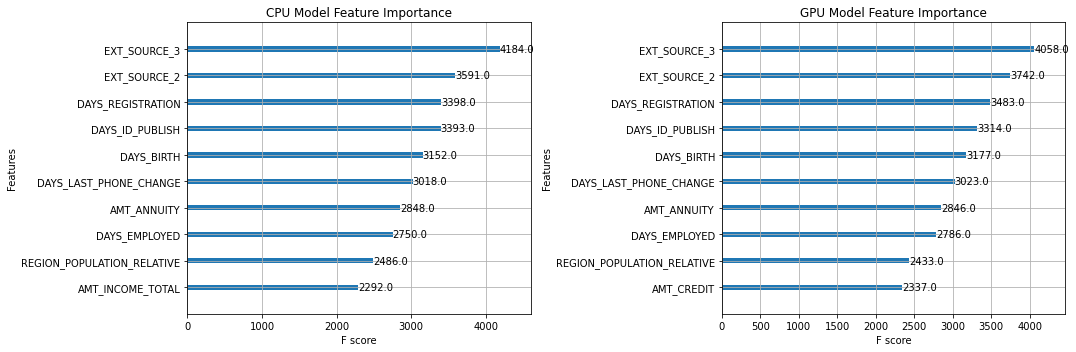

In [14]:
def run_analysis():
    print("=== Running Pandas/CPU Implementation ===")
    # Preprocess
    train_pd_proc, test_pd_proc, target_pd = preprocess_pandas(train_pd, test_pd)
    
    # Train/Test split
    X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
        train_pd_proc, target_pd, test_size=0.2, random_state=42
    )
    
    # Train and evaluate
    model_pd = train_model_cpu(X_train_pd, y_train_pd, X_test_pd, y_test_pd)
    y_pred_pd = evaluate_model(model_pd, X_test_pd, y_test_pd, "pandas")
    
    print("\n=== Running RAPIDS/GPU Implementation ===")
    # Preprocess
    train_cu_proc, test_cu_proc, target_cu = preprocess_rapids(train_cu, test_cu)

    X_train_cu, X_test_cu, y_train_cu, y_test_cu = train_test_split(
    train_cu_proc, target_cu, test_size=0.2, random_state=42
)
    # Train and evaluate
    model_cu = train_model_gpu(X_train_cu, y_train_cu, X_test_cu, y_test_cu)
    y_pred_cu = evaluate_model(model_cu, X_test_cu, y_test_cu, "rapids")
    # Compare feature importance
    compare_feature_importance(model_pd, model_cu, train_pd_proc.columns)

if __name__ == "__main__":
    run_analysis()